# Assignment

We build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans




In [2]:
import pandas as pd
col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("../data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


Run the feature engineering steps on the data to extract RFM features.  

In [3]:
churn['date'] =  pd.to_datetime(pd.to_datetime(churn['timestamp'], format = '%m/%d/%Y %H:%M').dt.date)
churn_agg = churn.groupby(['user_id', 'date']).agg({'dollar': 'sum', 'quantity': 'sum'})
churn_agg = churn_agg.reset_index()
churn_roll = pd.DataFrame()
churn_roll['dollar_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['dollar'].sum()
churn_roll['quantity_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum()
churn_roll = churn_roll.reset_index()
churn_roll['last_visit_ndays'] = churn_agg.groupby('user_id')['date'].diff(periods = 1).dt.days
print(churn_roll.shape)

# Should we impute or drop NaN/NaT in churn_roll['last_visit_ndays']?
imputation_value = churn_roll['last_visit_ndays'].max() # None # 
if imputation_value is None:
    # Drop (Remove all rows with NaN):
    churn_roll.dropna(inplace = True)
    print(churn_roll.shape)
else:
    # Impute (Replace all NaN in last_visit_ndays):
    churn_roll['last_visit_ndays'] = churn_roll['last_visit_ndays'].fillna(imputation_value)

churn_roll.head()

(37058, 5)


,user_id,date,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1113,2000-11-12,420.0,5.0,118.0
1,1113,2000-11-26,558.0,3.0,14.0
2,1113,2000-11-27,1182.0,9.0,1.0
3,1113,2001-01-06,628.0,9.0,40.0
4,1250,2001-02-04,734.0,5.0,118.0


The RFM features are:  'dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays'

1. Train a k-means algorithm on the 3 normalized RFM features using $k = 10$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the normalized scale. <span style="color:red" float:right>[2 point]</span> 

I copied the below code from the class lecture and adapted it to this data set. First I normalized the data and then assigned the number of clusters to 10. I then used the rescaled data to create the clusters and then present the clusters but those are the normalized scale. Below I report it on the original scale.  

In [4]:
churn_rescaled = churn_roll[['dollar_roll_sum_7D','quantity_roll_sum_7D','last_visit_ndays']] # this section is the normalization code
churn_rescaled = churn_rescaled.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)
churn_rescaled.head().round(2)

n_clusters = 10 # the number of clusters (k)
ClusterCols2D = ['dollar_roll_sum_7D','quantity_roll_sum_7D','last_visit_ndays'] # this is assigning the number of clusters and the columns to a name

X = churn_rescaled[ClusterCols2D]
kmeans = KMeans(n_clusters = n_clusters) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
churn_rescaled.head().round(2)

print('scaled cluster centroids:')
ScaledCentroids = pd.DataFrame(kmeans.cluster_centers_, columns=ClusterCols2D)
display(ScaledCentroids)
print('\nNumber of items in each cluster:')
print(churn_rescaled.cluster.value_counts())


scaled cluster centroids:


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,-0.368764,-0.312372,-0.683511
1,0.666070,0.563981,1.498450
2,1.067349,0.956984,-0.685185
3,8.944504,43.944981,-0.831760
4,9.860147,3.717116,-0.657675
5,-0.306505,-0.271662,1.539893
6,0.167097,0.219371,-0.723222
7,21.614177,10.192770,-0.771665
8,3.106452,2.095733,-0.434910
9,-0.275777,-0.264317,0.085807



Number of items in each cluster:
0    13171
5     8228
6     7016
9     3386
2     2480
1     2094
8      578
4       70
7       25
3       10
Name: cluster, dtype: int64


These are the centroids presented with the orginal data. I unnormalized them with the below code. 

In [5]:

Centroids = pd.DataFrame()
Centroids = ScaledCentroids * churn_roll[ClusterCols2D].std() + churn_roll[ClusterCols2D].mean()
Centroids

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,468.203854,6.256506,10.704727
1,2616.724665,25.395315,115.273423
2,3449.858933,33.978173,10.624495
3,19804.400000,972.800000,3.600000
4,21705.457143,94.257143,11.942857
5,597.465857,7.145565,117.259538
6,1580.758060,17.869330,8.801569
7,46109.160000,235.680000,6.480000
8,7683.443674,58.847487,22.618718
9,661.263204,7.305990,47.573621


2. Our earlier choice of $k=10$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 1 to 15. <span style="color:red" float:right>[4 point]</span>

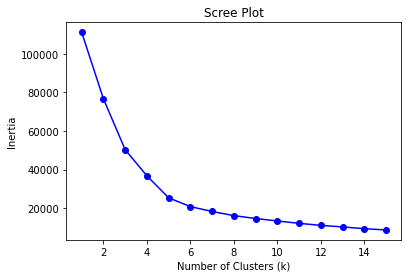

In [8]:


# Range of cluster numbers to consider
k_values = range(1, 16)

# Initialize an empty list to store the inertia values
inertia_values = []

# Perform K-means clustering for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plotting the scree plot using inertia values
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Scree Plot')
plt.show()


3. Based on the scree plot, what is a good value to pick for $k$? Provide a brief justification for your choice. <span style="color:red" float:right>[2 point]</span>

I picked 5 because its right at the 'elbow' of the graph, or in otherwords its about where you start seeing smaller and smaller differences between the clusters and therefore you'll experience demisnishing returns on information you get from having more clusters. 

**Add Comment here**   


4. Train a k-means algorithm on the RFM features using your new value of $k$. Report:
- the size (number of items) of each cluster
- the mean of each cluster in the original scale
- the standard deviation of each cluster in the Z-normalized scale
<span style="color:red" float:right>[2 point]</span>

In [7]:
churn_rescaled = churn_roll[['dollar_roll_sum_7D','quantity_roll_sum_7D','last_visit_ndays']] # this section is the normalization code
churn_rescaled = churn_rescaled.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)
churn_rescaled.head().round(2)

n_clusters = 5 # the number of clusters (k)
ClusterCols2D = ['dollar_roll_sum_7D','quantity_roll_sum_7D','last_visit_ndays'] # this is assigning the number of clusters and the columns to a name

X = churn_rescaled[ClusterCols2D]
kmeans = KMeans(n_clusters = n_clusters) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
churn_rescaled.head().round(2)


print('\nNumber of items in each cluster:')
print(churn_rescaled.cluster.value_counts())
print('\nMean of each cluser on orginial scale')
Centroids = pd.DataFrame()
Centroids = ScaledCentroids * churn_roll[ClusterCols2D].std() + churn_roll[ClusterCols2D].mean()
print(Centroids)


print('\nStandard deviation of each cluster in the Z-normalized scale:')
std_deviation = churn_rescaled.groupby('cluster').std()
print(std_deviation.round(2))



Number of items in each cluster:
0    23196
1    10639
4     3156
3       57
2       10
Name: cluster, dtype: int64

Mean of each cluser on orginial scale
   dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
0          468.203854              6.256506         10.704727
1         2616.724665             25.395315        115.273423
2         3449.858933             33.978173         10.624495
3        19804.400000            972.800000          3.600000
4        21705.457143             94.257143         11.942857
5          597.465857              7.145565        117.259538
6         1580.758060             17.869330          8.801569
7        46109.160000            235.680000          6.480000
8         7683.443674             58.847487         22.618718
9          661.263204              7.305990         47.573621

Standard deviation of each cluster in the Z-normalized scale:
         dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
cluster                        

5. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features). <span style="color:red" float:right>[3 point]</span>

The '0' group is the largest group and it has the smallest average quanitity. The '4' group is the smallest group and with the by far biggest dollar summary. Group '2' is the second smallest group and has the most recent last visit. 


# End of assignment